In [18]:
import os
import cv2
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision.transforms import Compose, ToTensor, Resize, Normalize
from PIL import Image
import numpy as np


In [85]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class RViT(nn.Module):
    def __init__(self, num_classes, hidden_dim, num_layers, frame_dim):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Patch embedding
        self.patch_embedding = nn.Conv3d(3, hidden_dim, kernel_size=(3, 8, 8), stride=(3, 4, 4), padding=(1, 2, 2))
        self.position_encoding = nn.Parameter(torch.randn(1, hidden_dim, 1, 56, 56), requires_grad=True)

        # Spatiotemporal Transformer Units
        self.rvit_units = nn.ModuleList([RViTUnitWithTemporal(hidden_dim) for _ in range(num_layers)])
        
        # Classifier
        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        # Patch embedding
        patches = self.patch_embedding(x)
        
        # Add positional encoding
        _, _, depth, height, width = patches.shape
        pos_encoding = nn.functional.interpolate(self.position_encoding, size=(depth, height, width), mode='trilinear', align_corners=False)
        patches += pos_encoding

        # Flatten spatial dimensions for temporal processing
        batch_size, hidden_dim, depth, height, width = patches.size()
        patches = patches.permute(0, 2, 1, 3, 4).reshape(batch_size, depth, hidden_dim, -1)
        patches = patches.mean(-1)  # Average pooling across spatial dimensions (or keep it flattened)

        # Recurrent Spatiotemporal Processing
        for unit in self.rvit_units:
            patches = unit(patches)

        # Classification
        h_last = patches.mean(dim=1)  # Global average pooling over the sequence length
        logits = self.classifier(h_last)
        return logits




class ScaledDotProductAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.scale = hidden_dim ** -0.5

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)
        k = self.Wk(h)
        v = self.Wv(h)
        
        # Compute scaled dot-product attention
        attn = torch.softmax((q * k).sum(dim=1, keepdim=True) * self.scale, dim=-1)
        output = attn * v  # Apply attention weights to values
        
        return output
        
class LinearAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wk = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wv = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)
        self.Wo = nn.Conv3d(hidden_dim, hidden_dim, kernel_size=1)

    def forward(self, x, h):
        # Compute queries, keys, and values
        q = self.Wq(x)  # Shape: [batch_size, hidden_dim, depth, height, width]
        k = self.Wk(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        v = self.Wv(h)  # Shape: [batch_size, hidden_dim, depth, height, width]
        
        # Reshape q and k for attention computation
        q = q.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        k = k.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]
        v = v.flatten(start_dim=2)  # Shape: [batch_size, hidden_dim, depth*height*width]

        # Compute attention weights
        attn_weights = torch.bmm(q.transpose(1, 2), k)  # Shape: [batch_size, depth*height*width, depth*height*width]
        attn_weights = attn_weights / (k.size(1) ** 0.5)  # Scale by sqrt of hidden_dim
        attn_weights = torch.softmax(attn_weights, dim=-1)  # Apply softmax over last dimension

        # Apply attention weights to values
        attn_output = torch.bmm(v, attn_weights.transpose(1, 2))  # Shape: [batch_size, hidden_dim, depth*height*width]
        
        # Reshape back to 3D
        attn_output = attn_output.view_as(h)  # Shape: [batch_size, hidden_dim, depth, height, width]

        # Final projection to match the input shape
        output = self.Wo(attn_output)  # Shape: [batch_size, hidden_dim, depth, height, width]
        return output

class SpatiotemporalAttention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.spatial_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8)
        self.temporal_attention = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=8)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # x: [batch_size, sequence_length, hidden_dim]
        # Spatial attention
        spatial_out, _ = self.spatial_attention(x, x, x)  # Self-attention
        spatial_out = self.layer_norm1(x + spatial_out)   # Add & Norm

        # Temporal attention
        temporal_out, _ = self.temporal_attention(spatial_out, spatial_out, spatial_out)
        temporal_out = self.layer_norm2(spatial_out + temporal_out)  # Add & Norm

        return temporal_out


class RViTUnitWithTemporal(nn.Module):
    def __init__(self, hidden_dim, dropout_rate=0.3):
        super().__init__()
        self.spatial_temporal_block = SpatiotemporalAttention(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.layer_norm = nn.LayerNorm(hidden_dim)

    def forward(self, x):
        # Spatiotemporal attention
        attention_out = self.spatial_temporal_block(x)
        attention_out = self.dropout(attention_out)

        # Feedforward network
        ffn_out = self.ffn(attention_out)
        output = self.layer_norm(attention_out + ffn_out)  # Add & Norm

        return output

In [67]:
import matplotlib.pyplot as plt

def visualize_attention(video_frames, spatial_weights, temporal_weights):
    # video_frames: [batch_size, 3, num_frames, height, width]
    # spatial_weights: [num_frames, height*width, height*width]
    # temporal_weights: [num_frames, num_frames]

    num_frames = video_frames.shape[2]
    fig, axes = plt.subplots(1, num_frames, figsize=(15, 5))
    for i in range(num_frames):
        # Show video frame
        frame = video_frames[0, :, i, :, :].permute(1, 2, 0).cpu().numpy()
        axes[i].imshow((frame - frame.min()) / (frame.max() - frame.min()))  # Normalize for visualization
        axes[i].set_title(f"Frame {i + 1}")
        axes[i].axis('off')

    plt.show()

    # Visualize spatial attention for the first frame
    plt.imshow(spatial_weights[0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    plt.title("Spatial Attention (First Frame)")
    plt.colorbar()
    plt.show()

    # Visualize temporal attention
    plt.imshow(temporal_weights.cpu().detach().numpy(), cmap='hot', interpolation='nearest')
    plt.title("Temporal Attention")
    plt.colorbar()
    plt.show()


In [86]:
import os
from collections import Counter
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, RandomHorizontalFlip, RandomRotation, ColorJitter, Resize, ToTensor, Normalize

# Dataset class for images
class ActionVideoFromImagesDataset(Dataset):
    def __init__(self, root_dir, num_frames=16, transform=None):
        """
        Args:
            root_dir (str): Path to the root directory containing action label folders.
            num_frames (int): Number of frames to sample per pseudo-video.
            transform (callable, optional): Transform to apply to each frame.
        """
        self.root_dir = root_dir
        self.num_frames = num_frames
        self.transform = transform
        self.data = []
        self.labels = []
        self.classes = os.listdir(root_dir)

        # Load dataset: Store paths of image files and corresponding labels
        for label, action in enumerate(self.classes):
            action_dir = os.path.join(root_dir, action)
            image_files = sorted(os.listdir(action_dir))  # Sort for consistent sequence
            self.data.append((image_files, label, action_dir))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        """
        Returns:
            frames (torch.Tensor): Tensor of shape [C, D, H, W].
            label (int): Action label.
        """
        image_files, label, action_dir = self.data[idx]

        # Sample `num_frames` images
        if len(image_files) >= self.num_frames:
            selected_files = image_files[:self.num_frames]  # Sequential sampling
        else:
            selected_files = image_files  # Use all available images

        frames = []
        for file in selected_files:
            img_path = os.path.join(action_dir, file)
            img = Image.open(img_path).convert("RGB")  # Ensure RGB format
            if self.transform:
                img = self.transform(img)
            frames.append(img)

        # Pad with empty frames if fewer than `num_frames`
        while len(frames) < self.num_frames:
            frames.append(torch.zeros_like(frames[0]))

        # Stack frames along the temporal depth dimension
        frames = torch.stack(frames, dim=0)  # Shape: [D, C, H, W]
        frames = frames.permute(1, 0, 2, 3)  # Rearrange to [C, D, H, W]

        return frames, label



class ActionVideoDatasetSingle(Dataset):
    def __init__(self, video_dir, num_frames=16, transform=None):
        self.video_dir = video_dir
        self.num_frames = num_frames
        self.transform = transform
        self.classes = os.listdir(video_dir)  # List of action folder names
        self.label_to_class = {i: cls for i, cls in enumerate(self.classes)}  # Map index to folder name

        # Select one video per action label folder
        self.video_files = []
        for label, cls in enumerate(self.classes):
            action_folder = os.path.join(video_dir, cls)
            videos = [f for f in os.listdir(action_folder) if f.endswith('.mp4')]
            if videos:
                self.video_files.append((os.path.join(action_folder, videos[0]), label))

    def __len__(self):
        return len(self.video_files)

    def __getitem__(self, idx):
        video_path, label = self.video_files[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        while len(frames) < self.num_frames:
            ret, frame = cap.read()
            if not ret:
                break
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame = Image.fromarray(frame)  # Convert NumPy array to PIL image
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)
        cap.release()

        # If fewer frames than num_frames, pad with zeros
        while len(frames) < self.num_frames:
            frames.append(torch.zeros_like(frames[0]))

        # Stack frames along the depth dimension
        frames = torch.stack(frames, dim=0)  # Shape: [D, C, H, W]
        frames = frames.permute(1, 0, 2, 3)  # Rearrange to [C, D, H, W]

        # print(f"Frame shape: {frames.shape}")  # Should be [3, num_frames, height, width]
        return frames, label, video_path




# Transforms
image_transform = Compose([
    Resize((224, 224)),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

from torchvision.transforms import RandomCrop, RandomHorizontalFlip

video_transform = Compose([
    Resize((224, 224)),
    RandomHorizontalFlip(p=0.5),
    RandomCrop((200, 200), pad_if_needed=True),  # Adds spatial variety
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


test_dataset = ActionVideoDatasetSingle(video_dir='resized_videos', num_frames=16, transform=video_transform)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)  # Adjust batch_size if needed


# Parameters for class balancing
target_count = 15  # Define the target number of images per class

# Load datasets with augmentation for imbalance correction
train_dataset = ActionVideoFromImagesDataset(
    root_dir='action_sp',
    num_frames=16,
    transform=image_transform
)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_dataset = ActionVideoDatasetSingle(video_dir='resized_videos', transform=video_transform)

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Confirm updated dataset statistics
print(f"Number of training samples: {len(train_dataset)}")


Number of training samples: 21


In [102]:
class LabelSmoothingLoss(nn.Module):
    def __init__(self, smoothing=0.1):
        super(LabelSmoothingLoss, self).__init__()
        self.smoothing = smoothing

    def forward(self, logits, target):
        num_classes = logits.size(-1)
        one_hot = torch.zeros_like(logits).scatter(1, target.unsqueeze(1), 1)
        smooth_target = one_hot * (1 - self.smoothing) + self.smoothing / num_classes
        loss = -torch.sum(smooth_target * torch.log_softmax(logits, dim=-1), dim=-1).mean()
        return loss

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RViT(num_classes=21, hidden_dim=256, num_layers=4, frame_dim=(3, 224, 224)).to(device)

In [76]:
video_frames, true_label, video_path = next(iter(test_loader))
video_frames = video_frames.to(device)
logits, spatial_weights, temporal_weights = model(video_frames)

visualize_attention(video_frames, spatial_weights, temporal_weights)


In [108]:
from torch.optim.lr_scheduler import CosineAnnealingLR

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.CrossEntropyLoss()
criterion = LabelSmoothingLoss(smoothing=0.3)


scheduler = CosineAnnealingLR(optimizer, T_max=10)  # T_max is the number of epochs to restart

# for epoch in range(200):
#     model.train()
#     total_loss = 0
#     for inputs, labels in train_loader:
#         inputs, labels = inputs.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         total_loss += loss.item()
    
#     scheduler.step()  # Update the learning rate
#     print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader)}, LR = {scheduler.get_last_lr()[0]:.6f}")

for epoch in range(200):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Apply Label Smoothing Loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch + 1}: Loss = {total_loss / len(train_loader)}")



Epoch 1: Loss = 3.027306159337362
Epoch 2: Loss = 3.0454324881235757
Epoch 3: Loss = 3.022809902826945
Epoch 4: Loss = 3.0720669428507485
Epoch 5: Loss = 3.0352381070454917
Epoch 6: Loss = 3.019014755884806
Epoch 7: Loss = 3.0587363243103027
Epoch 8: Loss = 3.0196732680002847
Epoch 9: Loss = 3.0392726262410483
Epoch 10: Loss = 3.043205420176188
Epoch 11: Loss = 3.06903068224589
Epoch 12: Loss = 3.0722222328186035
Epoch 13: Loss = 3.056096315383911
Epoch 14: Loss = 3.0666495164235434
Epoch 15: Loss = 3.060807466506958
Epoch 16: Loss = 3.0168678760528564
Epoch 17: Loss = 3.059206167856852
Epoch 18: Loss = 3.0579164028167725
Epoch 19: Loss = 3.0464284420013428
Epoch 20: Loss = 3.0367680390675864
Epoch 21: Loss = 3.017199675242106
Epoch 22: Loss = 3.036285718282064
Epoch 23: Loss = 3.0680174827575684
Epoch 24: Loss = 3.0591861406962075
Epoch 25: Loss = 3.0414160092671714
Epoch 26: Loss = 3.026486317316691
Epoch 27: Loss = 3.0624543825785318
Epoch 28: Loss = 3.0727701981862388
Epoch 29: Los

In [109]:
def validate_with_softmax(model, test_loader, device, class_names, top_k=3):
    model.eval()
    results = []
    output_file = "validation_results.txt"  # Define the output file name

    with open(output_file, "w") as file:  # Open the file for writing
        with torch.no_grad():
            for inputs, labels, video_path in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                # Compute softmax probabilities
                probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities
                top_probs, top_classes = probs.topk(top_k, dim=1)  # Get top-k predictions
                
                # Collect results
                for i in range(len(video_path)):
                    video_name = video_path[i]
                    true_label = class_names[labels[i].item()]
                    predicted_probs = top_probs[i].cpu().numpy()
                    predicted_classes = [class_names[idx] for idx in top_classes[i].cpu().numpy()]
                    
                    result = {
                        "Video": video_name,
                        "True Label": true_label,
                        "Predicted Classes": predicted_classes,
                        "Probabilities": predicted_probs,
                    }
                    results.append(result)
                    
                    # Write to file
                    file.write(f"Video: {video_name}\n")
                    file.write(f"True Label: {true_label}\n")
                    file.write("Predicted Classes with Probabilities:\n")
                    for cls, prob in zip(predicted_classes, predicted_probs):
                        file.write(f"  {cls}: {prob:.4f}\n")
                    file.write("-" * 30 + "\n")
    
    return results

# Validate model and save results to file
results = validate_with_softmax(model, test_loader, device, class_names, top_k=3)

# Display some results
for result in results[:5]:  # Display the first 5 results
    print(f"Video: {result['Video']}")
    print(f"True Label: {result['True Label']}")
    print("Predicted Classes with Probabilities:")
    for cls, prob in zip(result['Predicted Classes'], result['Probabilities']):
        print(f"  {cls}: {prob:.4f}")
    print("-" * 30)

print("Validation results saved to 'validation_results.txt'")


Video: resized_videos/giving or receiving award/JBWeDivEHFI.mp4
True Label: giving or receiving award
Predicted Classes with Probabilities:
  abseiling: 0.0519
  milking cow: 0.0519
  wrestling: 0.0512
------------------------------
Video: resized_videos/wrapping present/HscLLuC-PQs.mp4
True Label: wrapping present
Predicted Classes with Probabilities:
  abseiling: 0.0519
  milking cow: 0.0519
  wrestling: 0.0512
------------------------------
Video: resized_videos/wrestling/yxJHCSA35Ns.mp4
True Label: wrestling
Predicted Classes with Probabilities:
  abseiling: 0.0519
  milking cow: 0.0519
  wrestling: 0.0512
------------------------------
Video: resized_videos/answering questions/j6ogVLOLQug.mp4
True Label: answering questions
Predicted Classes with Probabilities:
  abseiling: 0.0519
  milking cow: 0.0519
  wrestling: 0.0512
------------------------------
Video: resized_videos/checking tires/pqlY2l0KhEY.mp4
True Label: checking tires
Predicted Classes with Probabilities:
  abseiling:

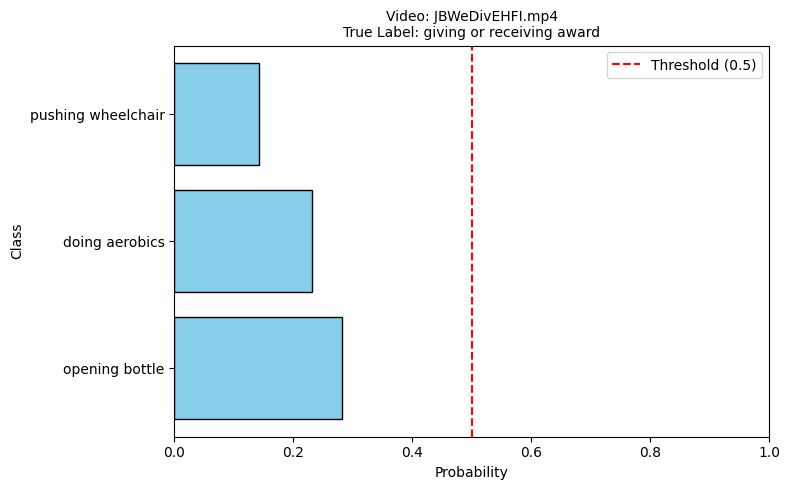

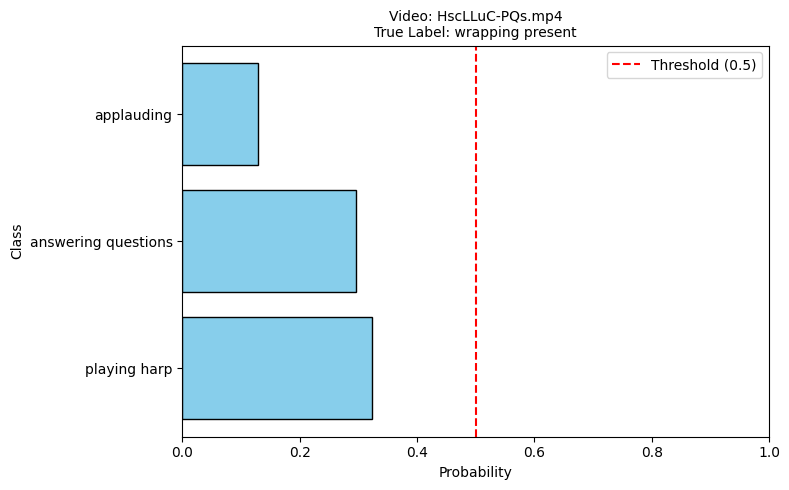

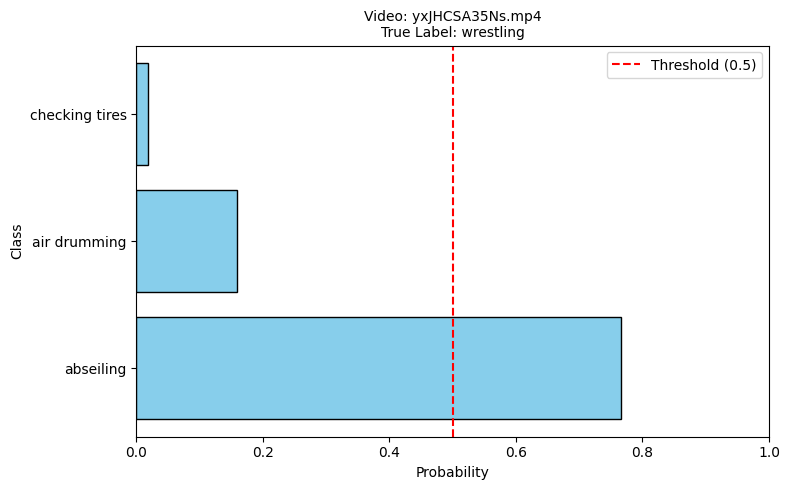

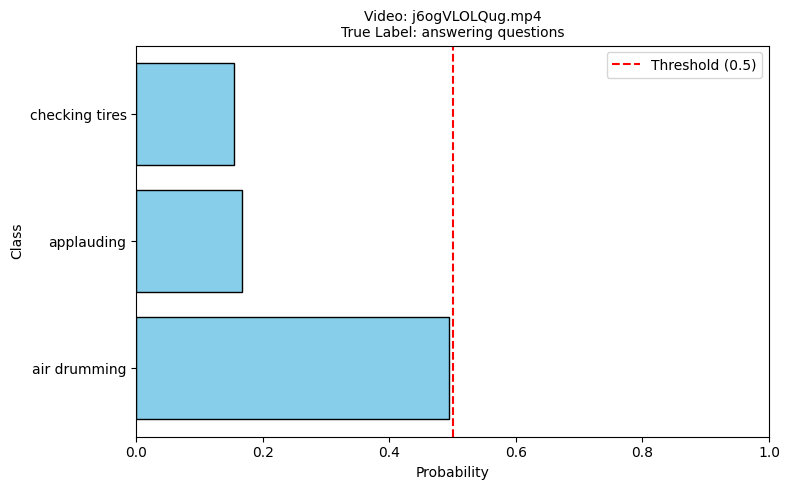

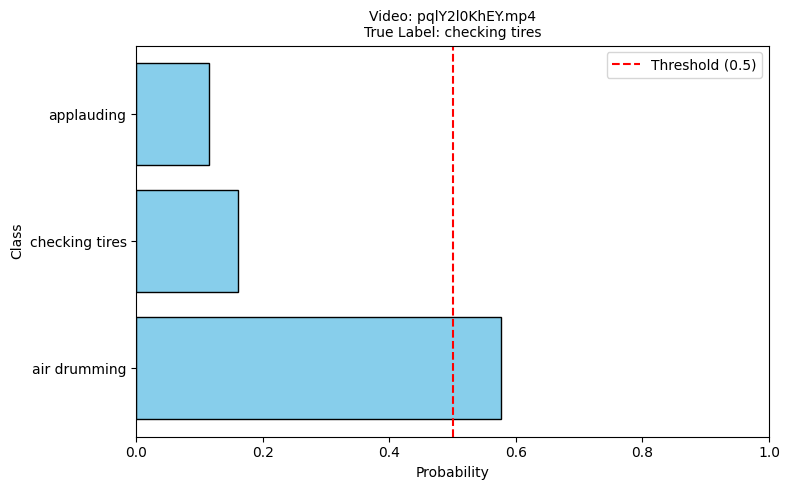

In [98]:
def plot_predictions(results, num_videos=5):
    """
    Plots bar charts for the top predictions of a subset of videos.

    Args:
        results (list): List of results containing 'True Label', 'Predicted Classes', and 'Probabilities'.
        num_videos (int): Number of videos to plot.
    """
    for i, result in enumerate(results[:num_videos]):
        plt.figure(figsize=(8, 5))
        predicted_classes = result['Predicted Classes']
        probabilities = result['Probabilities']
        true_label = result['True Label']

        # Bar plot
        plt.barh(predicted_classes, probabilities, color='skyblue', edgecolor='black')
        plt.axvline(0.5, color='red', linestyle='--', label="Threshold (0.5)")  # Optional threshold line
        plt.title(f"Video: {os.path.basename(result['Video'])}\nTrue Label: {true_label}", fontsize=10)
        plt.xlabel("Probability")
        plt.ylabel("Class")
        plt.xlim(0, 1)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Plot for the first 5 videos
plot_predictions(results, num_videos=5)


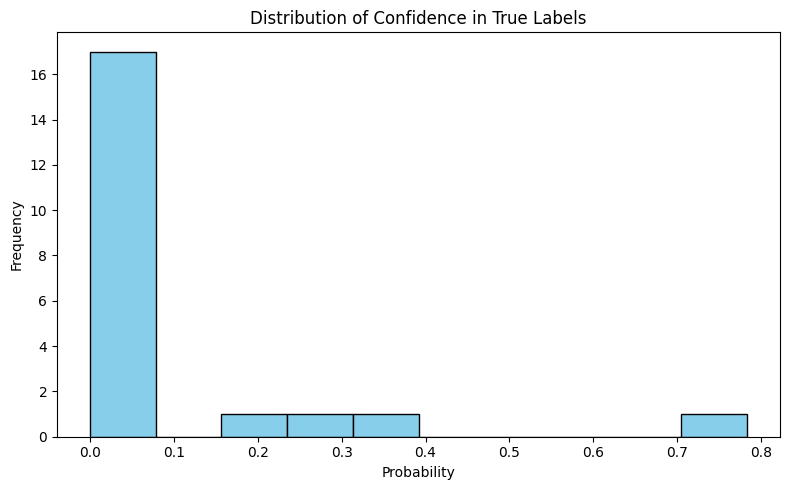

In [99]:
def plot_confidence_distribution(results):
    true_label_probs = []

    for result in results:
        if result['True Label'] in result['Predicted Classes']:
            index = result['Predicted Classes'].index(result['True Label'])
            true_label_probs.append(result['Probabilities'][index])
        else:
            true_label_probs.append(0)  # If true label isn't in top predictions, assign 0 confidence

    plt.figure(figsize=(8, 5))
    plt.hist(true_label_probs, bins=10, color='skyblue', edgecolor='black')
    plt.title("Distribution of Confidence in True Labels")
    plt.xlabel("Probability")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# Plot confidence distribution
plot_confidence_distribution(results)


Balancing images for each folder with image augmentation

In [ ]:
import os
from PIL import Image
import torch
from torchvision.transforms import (
    Compose, RandomHorizontalFlip, RandomRotation, ColorJitter,
    RandomResizedCrop, GaussianBlur, RandomPerspective
)
from tqdm import tqdm

class BalancedAugmentor:
    def __init__(self, root_dir, target_count=100, transform=None):
        """
        Args:
            root_dir (str): Path to the original dataset root directory.
            target_count (int): Desired number of images per action label after augmentation.
            transform (callable, optional): Transform to apply for augmentation.
        """
        self.root_dir = root_dir
        self.target_count = target_count
        self.transform = transform if transform else self.default_augmentation()

    def default_augmentation(self):
        """
        Defines the augmentation pipeline for intense augmentation.
        """
        return Compose([
            RandomResizedCrop(size=(224, 224), scale=(0.8, 1.2)),  # Random crop and resize
            RandomHorizontalFlip(p=0.5),
            RandomRotation(degrees=30),  # Random rotation
            ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2),
            GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 2.0)),
            RandomPerspective(distortion_scale=0.5, p=0.5),
        ])

    def augment_class(self, label_dir, label, current_count):
        """
        Augments a specific class to reach the target number of images.
        Args:
            label_dir (str): Directory containing images for the specific class label.
            label (str): Name of the label.
            current_count (int): Current number of images in the class folder.
        """
        image_files = os.listdir(label_dir)
        num_to_augment = self.target_count - current_count

        if num_to_augment > 0:
            print(f"Augmenting class '{label}' with {num_to_augment} new images.")
            for i in range(num_to_augment):
                img_path = os.path.join(label_dir, image_files[i % len(image_files)])
                img = Image.open(img_path).convert("RGB")  # Ensure all images are in RGB mode

                # Apply augmentation
                augmented_img = self.transform(img)

                # Save augmented image
                augmented_img_path = os.path.join(label_dir, f"{label}_aug_{i}.jpg")
                augmented_img.save(augmented_img_path)

    def balance_dataset(self):
        """
        Balances all classes by augmenting underrepresented ones.
        """
        action_labels = os.listdir(self.root_dir)
        for label in tqdm(action_labels, desc="Balancing Classes"):
            label_dir = os.path.join(self.root_dir, label)
            if not os.path.isdir(label_dir):
                continue  # Skip if it's not a directory
            current_count = len(os.listdir(label_dir))
            if current_count < self.target_count:
                self.augment_class(label_dir, label, current_count)

# Parameters
root_dir = 'action_sp'  # Original dataset path
target_count = 100  # Desired number of images per action label

# Perform balancing augmentation
augmentor = BalancedAugmentor(root_dir, target_count=target_count)
augmentor.balance_dataset()

# Verify final counts
final_counts = {label: len(os.listdir(os.path.join(root_dir, label))) for label in os.listdir(root_dir)}
print(f"Final image counts per class: {final_counts}")


=========================================================================================================================================================